In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [12]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [336]:
folder = os.listdir()

file = []
for f in folder:
    if "실거래가" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
gajwa = gajwa.dropna(axis=0)

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "0"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day


#원핫인코딩으로 전월세 구분하기
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])
#gajwa = pd.get_dummies(gajwa, columns = ["도로명"])

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./지역별_전월세전환율_20221112193907.csv", encoding="cp949")
rate = rate.T
rate = rate[2:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")

gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,year,month,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,12,15.0,202107,4,150,30,2016,가좌길48번길,2021,7,1,0,6.4,5775
1,경상남도 진주시 가좌동,1***,12,19.0,202107,17,200,30,2019,가좌길48번길,2021,7,1,0,6.4,5825
2,경상남도 진주시 가좌동,1***,12,19.0,202107,18,5000,10,2019,가좌길48번길,2021,7,1,0,6.4,6875
3,경상남도 진주시 가좌동,1***,8,19.8,202107,17,200,32,2017,가좌길60번길,2021,7,1,0,6.4,6200
4,경상남도 진주시 가좌동,1***,12,20.0,202107,21,100,25,2015,가좌길48번길,2021,7,1,0,6.4,4788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,경상남도 진주시 가좌동,1***,8,30.0,201910,20,6000,0,2018,가좌길44번길,2019,10,0,1,7.0,6000
1615,경상남도 진주시 가좌동,4**,12,33.0,201910,20,1500,30,2010,개양로6번길,2019,10,1,0,7.0,6643
1616,경상남도 진주시 가좌동,5**,12,25.0,201904,5,300,33,2007,진주대로500번길,2019,4,1,0,6.0,6900
1617,경상남도 진주시 가좌동,4**,12,27.0,201904,16,250,30,2007,개양로6번길,2019,4,1,0,6.0,6250


In [323]:
# 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)
# gajwa

In [337]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지","도로명", "계약일", "보증금(만원)", "월세(만원)", "전월세전환율"], axis=1)

gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전세전환가격
0,12,15.0,2016,2021,7,1,0,5775
1,12,19.0,2019,2021,7,1,0,5825
2,12,19.0,2019,2021,7,1,0,6875
3,8,19.8,2017,2021,7,1,0,6200
4,12,20.0,2015,2021,7,1,0,4788
...,...,...,...,...,...,...,...,...
1614,8,30.0,2018,2019,10,0,1,6000
1615,12,33.0,2010,2019,10,1,0,6643
1616,12,25.0,2007,2019,4,1,0,6900
1617,12,27.0,2007,2019,4,1,0,6250


# 머신러닝

In [351]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [339]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

In [341]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

## 선형회귀분석

In [342]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
print(f"variance score : {r2_score(y_test, y_preds):.3f}")

MSE : 1952877.369 RMSE: 1397.454
variance score : 0.593


In [343]:
lr.fit(X_train_standardized, y_train)
lr.score(X_test_standardized, y_test)

0.5771783311789033

## Ridge

In [344]:
R_model = Ridge()
R_model.fit(X_train, y_train)
print(R_model.score(X_test, y_test))

R_model.fit(X_train_standardized, y_train)
R_model.score(X_test_standardized, y_test)

0.5927548888098645


0.5770507701497398

## Lasso

In [345]:
L_model = Lasso(alpha=0.5)
L_model.fit(X_train, y_train)
print(L_model.score(X_test, y_test))

L_model.fit(X_train_standardized, y_train)
L_model.score(X_test_standardized, y_test)

0.5927444170906662


0.5770794210713412

## ElasticNet

In [346]:
ela = ElasticNet(alpha=0.5)
ela.fit(X_train, y_train)
print(ela.score(X_test, y_test))

ela.fit(X_train_standardized, y_train)
ela.score(X_test_standardized, y_test)

0.5715387900781675


0.527454580829321

## 랜덤포레스트

In [347]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
randomforest_model.score(X_test_standardized, y_test)

0.6766030076429215


0.703970042749174

## 결정 트리 회귀

In [348]:
decisiontree_mae = DecisionTreeRegressor(criterion="mae", random_state=0)
model_mae = decisiontree_mae.fit(X_train, y_train)
model_mae.score(X_test, y_test)

/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


0.4135482475980258

In [364]:
xgboost = XGBRegressor(n_estimators=50)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost = xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.6973078207750172


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.7060384876948637

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

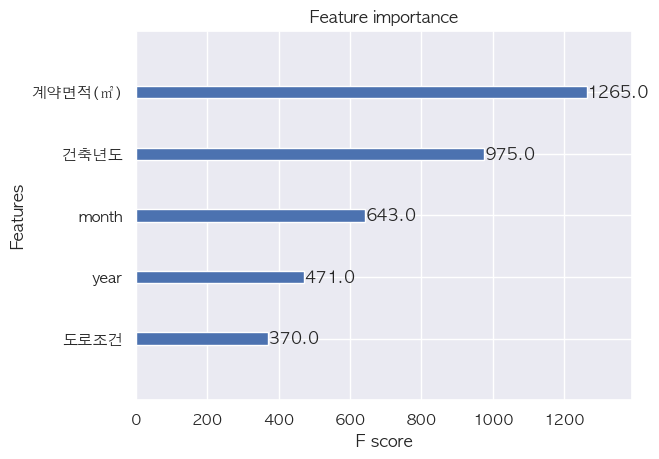

In [277]:
plot_importance(xgboost)

## 데이터시각화

In [278]:
corr = gajwa_data.corr()
corr

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격
도로조건,1.000000,0.132349,-0.101469,0.027625,-0.020996,0.106624
계약면적(㎡),0.132349,1.000000,-0.161862,-0.055696,0.091078,0.666579
건축년도,-0.101469,-0.161862,1.000000,0.155967,-0.053328,0.002639
year,0.027625,-0.055696,0.155967,1.000000,-0.266773,-0.068923
month,-0.020996,0.091078,-0.053328,-0.266773,1.000000,0.099238
전세전환가격,0.106624,0.666579,0.002639,-0.068923,0.099238,1.000000


## 카카오맵api

In [365]:
import folium

m = folium.Map(location=[37.53897093698831, 127.054619553077439], zoom_start=14)

ModuleNotFoundError: No module named 'folium'